## Getting the software ready

 1. **Anaconda**
 
In this tutorial, we are going to use the common analysis software in High Energy Experiment(HEP) called ROOT.
The easiest way to obtain it on a MAC is through anaconda.

Anaconda is a source-code distribution platform that help you download and manages a lot of scientific/data science packages. It helps you to maintain a correct dependency of each package,

You can obtain anaconda here:
https://www.anaconda.com/products/individual

I would recommend using the python3 version.

 2. **ROOT and Jupyter Notebook**
 
 The minimal packages we need are ROOT and jupyter notebook, which can be simply downloaded with:

```
conda install -c conda-forge root
conda install -c conda-forge notebook
```

`ROOT` may have some trouble working with `python3`. You can create a virtual environment specifying root with `python2.7` like this:

```
conda create --name pyroot root python=2.7
```

And then you can enter and exit the environment with 
```
conda activate pyroot
conda deactivate pyroot
```

In [1]:
#Import the packages
import ROOT as r
import numpy as np
import math

Welcome to JupyROOT 6.22/00


### The datasets

 1. **Data - Double Muon data**

We will be using proton-proton collision data at $\sqrt{s}=8 TeV$ taken during 2012 by the CMS.

Of course, we will not be using all of them, the dataset name 

`/DoubleMuParked/Run2012B-22Jan2013-v1/AOD`

tells you with subset of data we will be using.

Here `DoubleMuParked` means the data collected was triggered by a stream of High Level Trigger(HLT) trigger paths that targets muon, such as
```
HLT_DoubleMu5_IsoMu5
```
which means it requires two muons with at least 5 GeV and one of them is isolated from other particles.

More details can be found in this record:
http://opendata.cern.ch/record/6004
 
If you need to re-download the file, you can do:

`xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root .`

 1. **Z to $\mu\mu$ simultion**

In part II of the execise, we will be comparing the data collected with simulation. These simulated datasets correspond to the collision data collected by the CMS experiment in 2012.

The dataset name is: 

`/DYToMuMu_M-20_CT10_8TeV-powheg-pythia6/Summer12_DR53X-PU_S10_START53_V19-v1/AODSIM`

The dataset name follows a specific convention to provide a self-explanatory description of the dataset.

It follows a pattern like this:

`/Primary dataset/Condition/Format/`

The `Primary dataset` tells you about the process for a simulation dataset, and the data taking period and trigger stream that the data was collected if it is data.

The `Condition` part tells you what reconstruction condition has been applied to the dataset.

Lastly, the `Format` part tells you the dataformat. We will work with the simplified version of `MINIAOD` format, called `NanoAOD`, which I have prepared for you in advance.**

The dataset is downloaded from here. The file `dy_mc.root` is a tiny fraction of the whole dataset, as we do not need the whole 14TB of events.  
http://opendata.cern.ch/record/7741


<br>
<br>
<br>


** In case you are curious, the conversion is done also with cms open software here:

https://github.com/cms-opendata-analyses/AOD2NanoAODOutreachTool

## Exploring the data

In this section, we will go over some of the basic operations to explore a root file, working with the file on real data first.


In [2]:
#Opening a ROOT file
f = r.TFile("Run2012B_DoubleMuParked.root")
# list the content of the file
f.ls()

TFile**		Run2012B_DoubleMuParked.root	chain files
 TFile*		Run2012B_DoubleMuParked.root	chain files
  KEY: TTree	Events;1	Events


### TTree
TTree is the main object that holds the data. 

In general, all the objects in a TFile can be obtained with the `Get` Method

In [3]:
t = f.Get("Events")

In [15]:
## See how many events are there in this tree
t.GetEntries()

29308627L

### TTree.Show()
 There a several methods to see what's inside a tree

`Show(n)` prints out the n-th event in the tree

In [4]:
t.Show(0)

======> EVENT:0
 run             = 194778
 luminosityBlock = 51
 event           = 12887941
 PV_npvs         = 1
 PV_x            = 0.0722459
 PV_y            = 0.0620935
 PV_z            = -0.0280992
 nMuon           = 2
 Muon_pt         = 52.0083, 
                  42.857
 Muon_eta        = 1.25232, 
                  1.65312
 Muon_phi        = 0.842417, 
                  -2.15482
 Muon_mass       = 0.105658, 
                  0.105658
 Muon_charge     = 1, 
                  -1
 Muon_pfRelIso03_all = -999, 
                  -999
 Muon_pfRelIso04_all = -999, 
                  -999
 Muon_tightId    = 0, 
                  0
 Muon_softId     = 0, 
                  0
 Muon_dxy        = -999, 
                  -999
 Muon_dxyErr     = -999, 
                  -999
 Muon_dz         = -999, 
                  -999
 Muon_dzErr      = -999, 
                  -999
 nElectron       = 0


### TTree.Print()

`Print()` gives you more information about the branches, esp dataformat. 

Here, `run/I` tells you that the branch `run` is of type integer

whereas, `PV_x/F` means PV_x is a float

Finally, `Muon_pt[nMuon]/F ` is a array of floats

In [5]:
t.Print()

******************************************************************************
*Tree    :Events    : Events                                                 *
*Entries : 29308627 : Total =      7292735124 bytes  File  Size = 3469131212 *
*        :          : Tree compression factor =   2.10                       *
******************************************************************************
*Br    0 :run       : run/I                                                  *
*Entries : 29308627 : Total  Size=  117248701 bytes  File Size  =     625943 *
*Baskets :      151 : Basket Size=     980480 bytes  Compression= 187.31     *
*............................................................................*
*Br    1 :luminosityBlock : luminosityBlock/i                                *
*Entries : 29308627 : Total  Size=  117250561 bytes  File Size  =     871296 *
*Baskets :      151 : Basket Size=     980992 bytes  Compression= 134.57     *
*...................................................

### Question: Why do we need a different data format for the Muon_pt branch?

#### TTree::Draw

Another very handy way to see the data is the `Draw` method.

This is an internal method to loop over all the events on a branch (very efficiently!),

and fill an histogram from the branch content

To visualize the histogram, we first need to create a Canvas.


In [5]:
c = r.TCanvas('c1','c1',800,600)

For example, we can look at the branch called `nMuon`

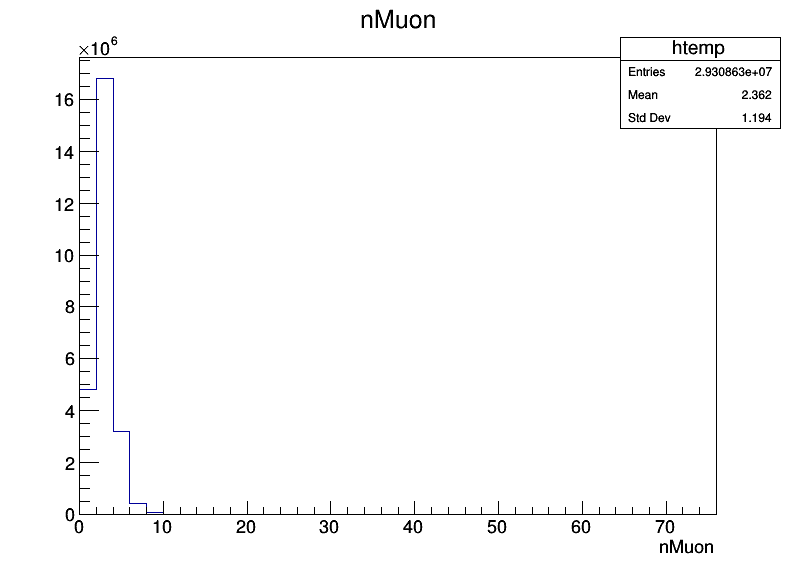

In [7]:
t.Draw('nMuon')
c.Draw()

### Question: Can you guess what does this histogram represents?

The branch names usually contains good description of what does it contain.

Similarly, we can explore another branch called `PV_npvs` as well

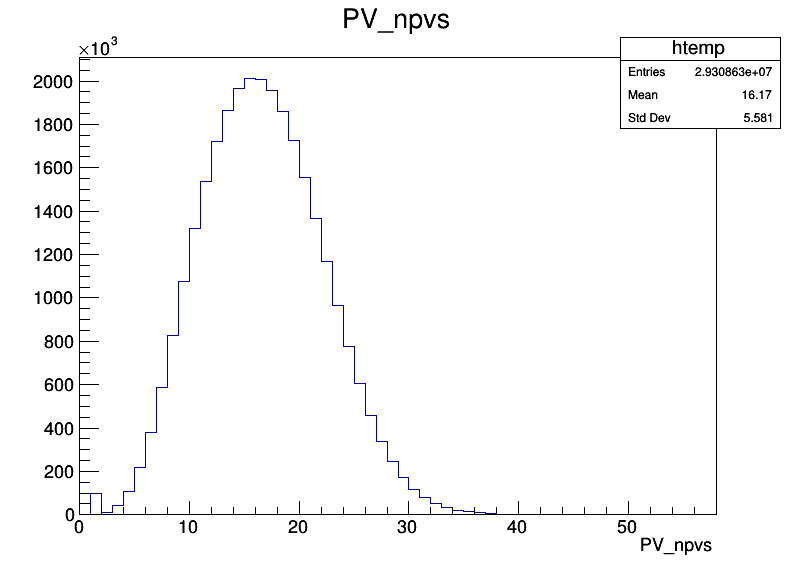

In [8]:
t.Draw("PV_npvs")
c.Draw()

### Question: Can you guess what `PV_npvs` represents then?

### Looping a TTree with a histogram

`TTree.Draw()` can only offer a simple plotting, for more custom analysis, we can go through the `TTree` event-by-event by building a for-loop.

Let's use a simple for-loop to re-create the `nMuon` histogram.

 - Learn how to create a histogram
 - Learn how to write a loop structure for a TTree

#### Defining a 1D histogram

`ROOT` has a very powerful library of histogram class called `TH1` with extensive functionalities.

You can construct a very simple 1D histogram like this:

`h = r.TH1F("name","title", nBin, x_low, x_hi)` 

 - `TH1F` is a sub-class of `TH1`, using a `float` to store the data of each bin of the histogram
 - `name` is the name of the histogram object, it is used to identify the histogram object (h, in this case) in a file
 - `title` is the title to be displayed in plotting
 - `nBin` is the number of bins 
 - `x_low,x_hi` are the lower and upper range of the 1D histogram respectively.
 
 
Further documentation about `TH1` can be found here:
https://root.cern.ch/doc/master/classTH1.html

### Let's define our first histogram

In [6]:
h_nMuon = r.TH1F('nMuon','nMuon',10,0,10)
h_nMuon.Draw()
c.Update()
c.Draw()

### Filling a histogram

Say, if you have an event with 4 muons in it. You will want to put 1 event in the 4-th bin.

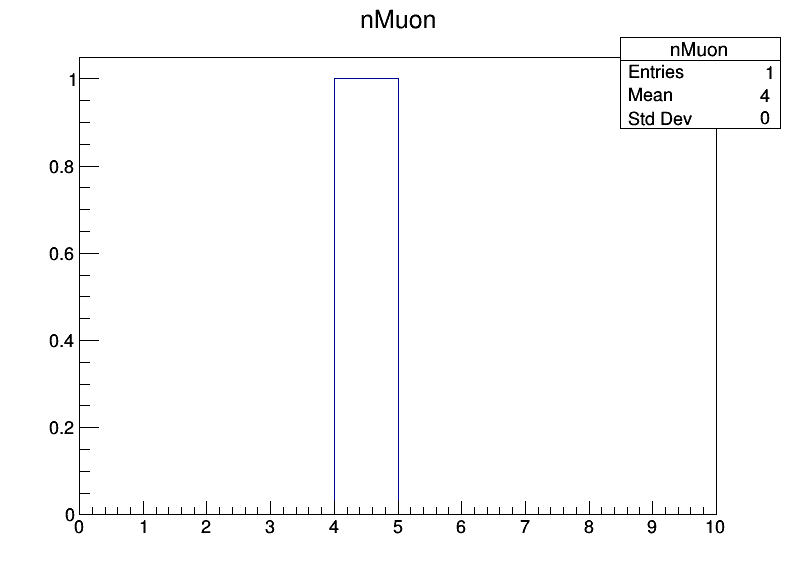

In [8]:
h_nMuon.Fill(4)
c.Update()
c.Draw()

In [13]:
## now let's clear the bin content, by setting the 5th bin to 0
h_nMuon.SetBinContent(5,0)

### Looping a TTree

By default, all the branches are loaded as the methods of the TTree object.

For example, you can simply access the `nMuon` branch like this:

`nMuon = t.nMuon`

**It will return the value of the tree is currently located

To access different events, we can do:

`t.GetEntry(i)`

This will set the memeory address to load the i-th entry in the Tree.

Combining both, a TTree can be looped over with the simple loop structure like this:

```
for i in range(0,t.GetEntries()):
    t.GetEntry(i)
    nMuon = t.nMuon
    h_nMuon.Fill(nMuon)
```

In [18]:
for i in range(0,t.GetEntries()):
    t.GetEntry(i)
    nMuon = t.nMuon
    h_nMuon.Fill(nMuon)

KeyboardInterrupt: 

### Note: You will notice this is significantly slower than `TTree::Draw()`.

This is because you are loading **all** branches in each events,

whereas `TTree::Draw` is only accessing one branch

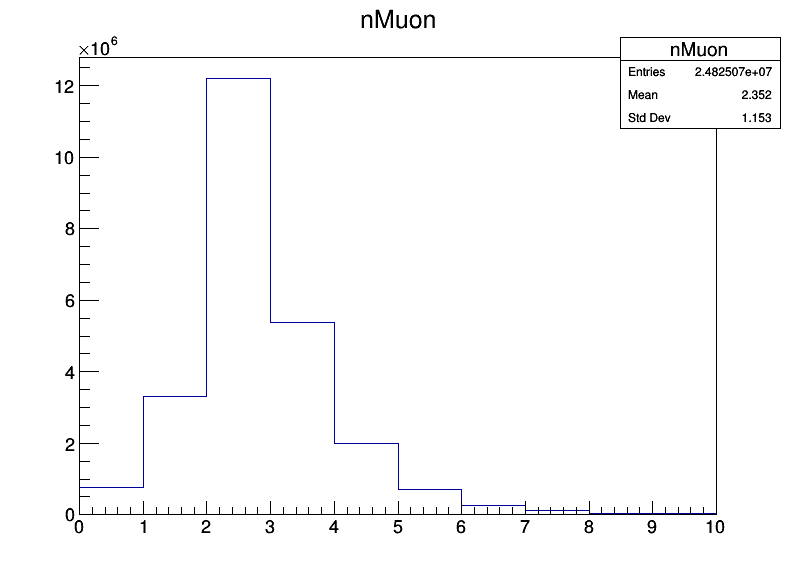

In [19]:
h_nMuon.Draw()
c.Update()
c.Draw()

### Plotting the di-muon mass spectrum

Now we have all the ingredients to plot the di-muon mass spectrum.

First, we will need a histogram.

In [21]:
h_dimuon_mass = r.TH1F('DiMuon_mass','DiMuon_mass',200,0,200)

In [28]:
## write a function that computes the invariant mass given the event
def invmass(pt,phi,eta,mass):
    
    m  = 2*pt[0]*pt[1]*(np.cosh(eta[0]-eta[1])-np.cos(phi[0]-phi[1]))
    ### Your code here:
    #m = 90
    return m

In [23]:
## write a function that select 
def selectMuons(muons):
    select = False

    ### Think about what event selection will give you a better di-Muon spectrum 
    ### that shows you a better Z-boson peak at 90 GeV.
    if muons['n']==2: select = True
    
    
    ### Your code here:    
    return select

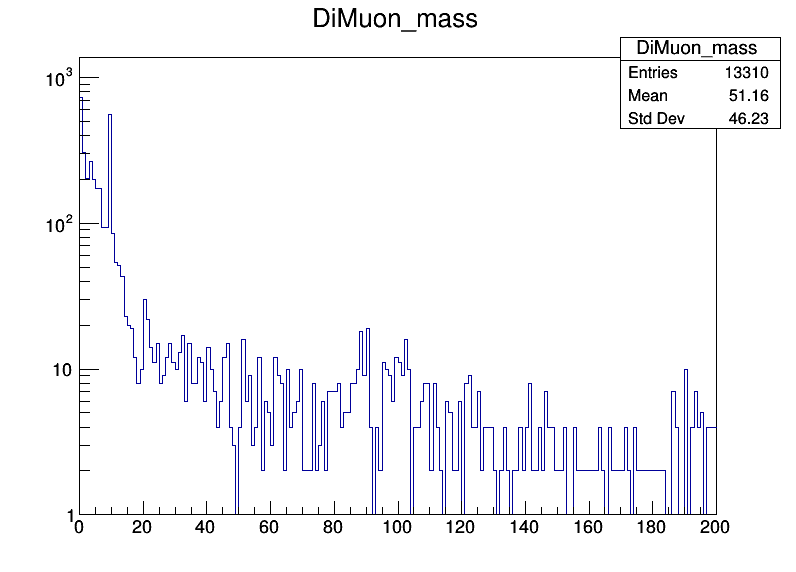

In [35]:
for i in range(0,10000):
    t.GetEntry(i)
    nMuon   = t.nMuon
    pt      = np.array(t.Muon_pt)          # note: this is an array
    phi     = np.array(t.Muon_phi)         # note: this is an array
    eta     = np.array(t.Muon_eta)         # note: this is an array 
    mass    = np.array(t.Muon_mass)        # note: this is an array
    isTight = np.array(t.Muon_tightId)     # note: this is an array
    charge  = np.array(t.Muon_charge)      # note: this is an array
    muons   = {
        'n':nMuon,
        'pt':pt,
        'phi':phi,
        'eta':eta,
        'isTight':isTight,
        'charge':charge,
    }
    if selectMuons(muons):
        h_dimuon_mass.Fill(invmass(pt,phi,eta,mass))
h_dimuon_mass.Draw()
c.Update()
c.SetLogy(1)
c.Draw()

# RESET the histogram if you want to try again!

In [32]:
for i in range(0,201): h_dimuon_mass.SetBinContent(i,0)

### Fitting a histogram

$f(x) = [0] exp\left(-\frac{1}{2}*((x-[1])/[2]\right)^2$

https://root.cern.ch/doc/master/classTF1.html

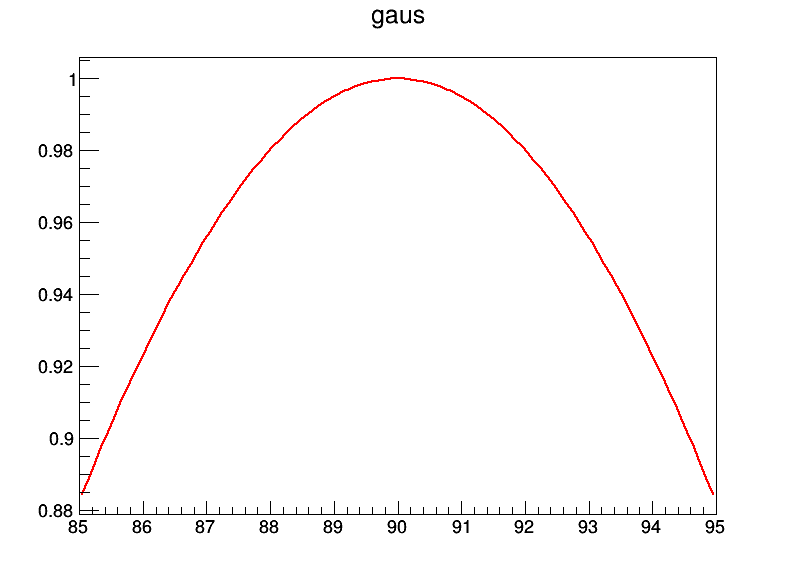

In [13]:
gaus = r.TF1('f1','gaus',85,95)
gaus.SetParNames('A','#mu','Sigma')
gaus.SetParameters(1,90,10)
gaus.Draw()
c.Draw()

In [14]:
fitResult = h_dimuon_mass.Fit(gaus,'RS')

 FCN=20.0184 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=1.02169e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            1.22228e+02   6.64069e+00   1.03615e-02  -5.67886e-05
   2  #mu          9.06519e+01   1.00641e-01   2.24827e-04  -3.48151e-03
   3  Sigma        2.37510e+00   1.15404e-01   2.63480e-05  -1.81895e-02


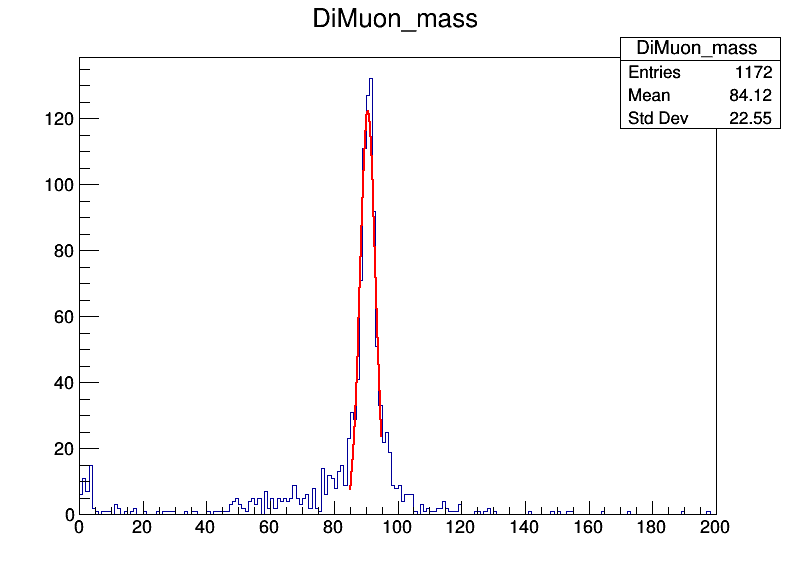

In [19]:
h_dimuon_mass.Draw()
c.Draw()

### Quality of the fit

In [24]:
chi2 = gaus.GetChisquare()
NDF  = gaus.GetNDF()
print('Checking fit quality:')
print("chi2 = %.3f\nNDF = %.3f\nchi2/NDF = %.3f"% (chi2,NDF, chi2/NDF))

Checking fit quality:
chi2 = 20.018
NDF = 7.000
chi2/NDF = 2.860
